<a href="https://colab.research.google.com/github/Apoorva-Bedekar/Twitter-Sentiment-Classification-using-Deep-Learning/blob/main/DL_Project_21201694.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP47650 - Deep Learning Project 

## Twitter Sentiment Analysis 

### Submitted by - Apoorva Bedekar (21201694)

> In this project I will be using B.2 (Text) Classification dataset. It is a Twitter sentiment analysis for multi-class clasiification for analysing polarity of the sentiment. The following are my target classes :
 1. Extremely Negative
 2. Negative
 3. Neutral 
 4. Positive 
 5. Extremely Positive

The main challenge in this dataset was sequential and require a robust model. 

 

#### Importing required libraries

In [2]:
import pandas as pd
import nltk
from collections import Counter
from matplotlib.pyplot import plot, hist, xlabel, legend
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import io
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import logging
import warnings
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)
warnings.filterwarnings("ignore")
from google.colab import files

#### Loading Data 

In [3]:
train = files.upload()
test = files.upload()

Saving Corona_NLP_train.csv to Corona_NLP_train.csv


Saving Corona_NLP_test.csv to Corona_NLP_test.csv


In [4]:
train= pd.read_csv(io.BytesIO(train['Corona_NLP_train.csv']), encoding='latin-1')
test = pd.read_csv(io.BytesIO(test['Corona_NLP_test.csv']),encoding='latin-1')

#### Initital analysis of the data

1.   Training and testing shape 
2.   Memory usage



In [5]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (41157, 6)
Training Set Memory Usage = 1.88 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


In [6]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
print('Data available for each target class: \n')
print(train.groupby('Sentiment').size())

Data available for each target class: 

Sentiment
Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7713
Positive              11422
dtype: int64


### Preprocessing the Text Data


#### Getting Target Classes 
Here we convert our 5 sentiment polarities into 5 numerical classes. 

*   Extremely Negative - 0
*   Negative - 1
*   Neutral - 2 
*   Positive - 3
*   Extremely Positive - 4

In [8]:
def get_target_class(df) :
    df['Target_class'] = df['Sentiment'].replace('Extremely Negative', 0).replace('Negative',1).replace('Neutral',2).replace('Positive',3).replace('Extremely Positive',4)
    return df

In [9]:
train_data = get_target_class(train)
test_data = get_target_class(test)

In [11]:
train_data.head()

,OriginalTweet,Target_class
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,3
2,Coronavirus Australia: Woolworths to give elde...,3
3,My food stock is not the only one which is emp...,3
4,"Me, ready to go at supermarket during the #COV...",0


#### Dropping column irrelevant to the analysis

In [10]:
train_data = train_data.drop(['UserName','ScreenName','Location','TweetAt','Sentiment'], axis = 1)
test_data = test_data.drop(['UserName','ScreenName','Location','TweetAt','Sentiment'], axis = 1)

####  Preprocessing 

*   Converting all tweet text to lower case for uniformity
*   Removing Stopwords
*   Count unique words to get vocabulary. 

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

In [14]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [15]:
train_data['raw_text']=  train_data.OriginalTweet.map(remove_stopwords)
test_data['raw_text']= test_data.OriginalTweet.map(remove_stopwords) 

In [16]:
train_data.head()

,OriginalTweet,Target_class,raw_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,@menyrbie @phil_gahan @chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia: woolworths give elderly...
3,My food stock is not the only one which is emp...,3,"food stock one empty... please, panic, enough ..."
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready go supermarket #covid19 outbreak. i'..."


#### Getting Vocabulary

In [17]:
train_counter = counter_word(train_data.raw_text)
test_counter = counter_word(test_data.raw_text)

In [18]:
train_vocab = len(train_counter)
test_vocab = len(test_counter)

print('Training Vocabulary %s'% len(train_counter))
print('Test Vocabulary %s'% len(test_counter))

Training Vocabulary 120642
Test Vocabulary 20457


#### Tokenizing, embedding and padding the text data



In [19]:
train_data['train_sentences'] = train_data.raw_text.to_numpy()
test_data['test_sentences'] = test_data.raw_text.to_numpy()

In [20]:
train_data['train_sentences'].shape, test_data['test_sentences'].shape

((41157,), (3798,))

In [21]:
train_data.head()

,OriginalTweet,Target_class,raw_text,train_sentences
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,@menyrbie @phil_gahan @chrisitv https://t.co/i...,@menyrbie @phil_gahan @chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia: woolworths give elderly...,coronavirus australia: woolworths give elderly...
3,My food stock is not the only one which is emp...,3,"food stock one empty... please, panic, enough ...","food stock one empty... please, panic, enough ..."
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready go supermarket #covid19 outbreak. i'...","me, ready go supermarket #covid19 outbreak. i'..."


Removing special symbols 

In [22]:
tokenizer = Tokenizer(num_words=train_vocab, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [23]:
tokenizer.fit_on_texts(train_data['train_sentences'])
tokenizer.fit_on_texts(test_data['test_sentences'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 87224 unique tokens.


Creating Sequences

In [24]:
train_data['train_sequences'] = tokenizer.texts_to_sequences(train_data['train_sentences'])
test_data['test_sequences'] = tokenizer.texts_to_sequences(test_data['test_sentences'])

In [25]:
train_data.head()

,OriginalTweet,Target_class,raw_text,train_sentences,train_sequences
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,@menyrbie @phil_gahan @chrisitv https://t.co/i...,@menyrbie @phil_gahan @chrisitv https://t.co/i...,"[25342, 7577, 25343, 14091, 3, 2, 1, 25344, 3,..."
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbours family exchange phone n...,"[429, 831, 2384, 183, 2661, 794, 1252, 1072, 3..."
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia: woolworths give elderly...,coronavirus australia: woolworths give elderly...,"[4, 795, 1607, 242, 216, 1328, 1906, 16, 181, ..."
3,My food stock is not the only one which is emp...,3,"food stock one empty... please, panic, enough ...","food stock one empty... please, panic, enough ...","[7, 22, 34, 123, 37, 20, 166, 7, 67, 65, 21, 4..."
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready go supermarket #covid19 outbreak. i'...","me, ready go supermarket #covid19 outbreak. i'...","[307, 664, 28, 10, 14, 73, 137, 4057, 7, 22, 2..."


Defining embedding dimension, trucating type, and padding type and maximum number of characters in a sentence. 
> * Truncate and pad the input sequences 
* Vectorize Tweet text
* Embedding dimension for mapping the original input data into set of real-valued dimensions. 

In [28]:
embedding_dim = 128
trunc_type='post'
padding_type='post'
# Max number of characters in a Tweet is 140 
max_length = 140

In [29]:
train_padded = pad_sequences(train_data['train_sequences'], maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_data['test_sequences'], maxlen=max_length, padding=padding_type, truncating=padding_type)

print('Shape of training data tensor:', train_padded.shape)
print('Shape of testing data tensor:', test_padded.shape)

Shape of training data tensor: (41157, 140)
Shape of testing data tensor: (3798, 140)


In [30]:
train_padded

array([[25342,  7577, 25343, ...,     0,     0,     0],
       [  429,   831,  2384, ...,     0,     0,     0],
       [    4,   795,  1607, ...,     0,     0,     0],
       ...,
       [   62,   116,   147, ...,     0,     0,     0],
       [  655,  4428,    32, ...,     0,     0,     0],
       [82623,   118,    43, ...,     0,     0,     0]], dtype=int32)

In [31]:
train_target_class = train_data['Target_class'].to_numpy()
test_target_class = test_data['Target_class'].to_numpy()

print('Shape of label tensor:', train_target_class.shape)
print('Shape of label tensor:', test_target_class.shape)

Shape of label tensor: (41157,)
Shape of label tensor: (3798,)


In [32]:
train_target_class

array([2, 3, 3, ..., 3, 2, 1])

#### Split Training data into Training and Validation Dataset

In [33]:
x_train,x_val,y_train,y_val = train_test_split(train_padded,train_target_class, test_size=0.33)

#### Function to plot graphs for loss and accuracy 

In [34]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['Training '+ string, 'Validation '+string])
  plt.show()

### Training Models 

*  RNN Bidirectional LSTM 
*  CONV1D + GlobalMaxPooling1D
*  SpatialDropout1D + Bidirectional LSTM 

#### Conv1D + Global Max Pooling

In [35]:
Model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(train_vocab, embedding_dim,input_length = max_length),
    tf.keras.layers.Conv1D(128, 5),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5,kernel_regularizer='l2', activation='softmax')])

In [36]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]
num_epochs = 10

In [37]:
Model1.summary()
Model1.compile(loss=loss, optimizer=optim, metrics=metrics)
history1 = Model1.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 128)          15442176  
                                                                 
 conv1d (Conv1D)             (None, 136, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 15,524,869
Trainable params: 15,524,869
Non-trainable params: 0
____________________________________________

KeyboardInterrupt: ignored

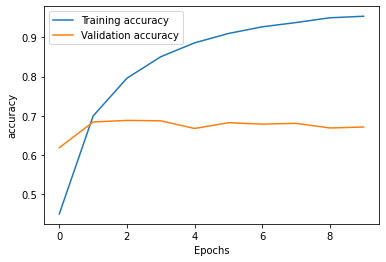

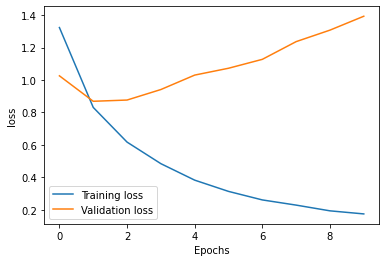

In [91]:
plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')

#### Bidirectional LSTM

In [92]:
Model2 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(train_vocab, embedding_dim, input_length = max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,dropout = 0.5,kernel_regularizer=tf.keras.regularizers.L2(0.001))), 
  #L2 Regularizers for avoiding overfitting 
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(5, activation="softmax") ])

In [93]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]
num_epochs = 10

In [94]:
Model2.summary()
Model2.compile(loss=loss, optimizer=optim, metrics=metrics)
history2 = Model2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 140, 100)          12064200  
                                                                 
 conv1d_6 (Conv1D)           (None, 136, 128)          64128     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 12,128,973
Trainable params: 12,128,973
Non-trainable params: 0
_________________________________________

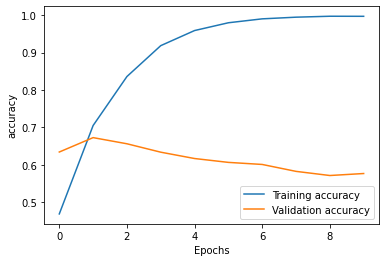

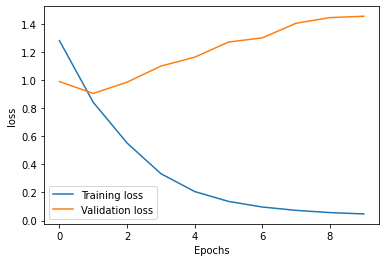

In [95]:
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

#### SpatialDropout1D + Bidirectional LSTM

In [96]:
Model3 =  tf.keras.Sequential([
  tf.keras.layers.Embedding(train_vocab, embedding_dim, input_length = max_length),
  tf.keras.layers.SpatialDropout1D(0.5),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,kernel_regularizer=tf.keras.regularizers.L2(0.001))),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(5, activation='softmax')])

In [97]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]
num_epochs = 10

In [98]:
Model3.summary()
Model3.compile(loss=loss, optimizer=optim, metrics=metrics)
history3 = Model3.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs,verbose=1)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 140, 100)          12064200  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 140, 100)         0         
 lDropout1D)                                                     
                                                                 
 dropout_17 (Dropout)        (None, 140, 100)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 5)               

In [1]:
plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

NameError: ignored

### Evaluation - Best model 

> SpatialDropout1D + LSTM


In [72]:
results2 = Model3.evaluate(test_padded, test_target_class)
print(results2)

119/119 [==============================] - 7s 55ms/step - loss: 0.9053 - accuracy: 0.6935
[0.9053305983543396, 0.6935229301452637]
